<a href="https://colab.research.google.com/github/Yufanzh/time_series_analysis/blob/main/RNN_Keras_sales_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./Alcohol_Sales.csv', index_col='DATE', parse_dates=True)

In [3]:
df.index.freq = 'MS'

In [4]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [5]:
df.columns = ['Sales']
df.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


<Axes: xlabel='DATE'>

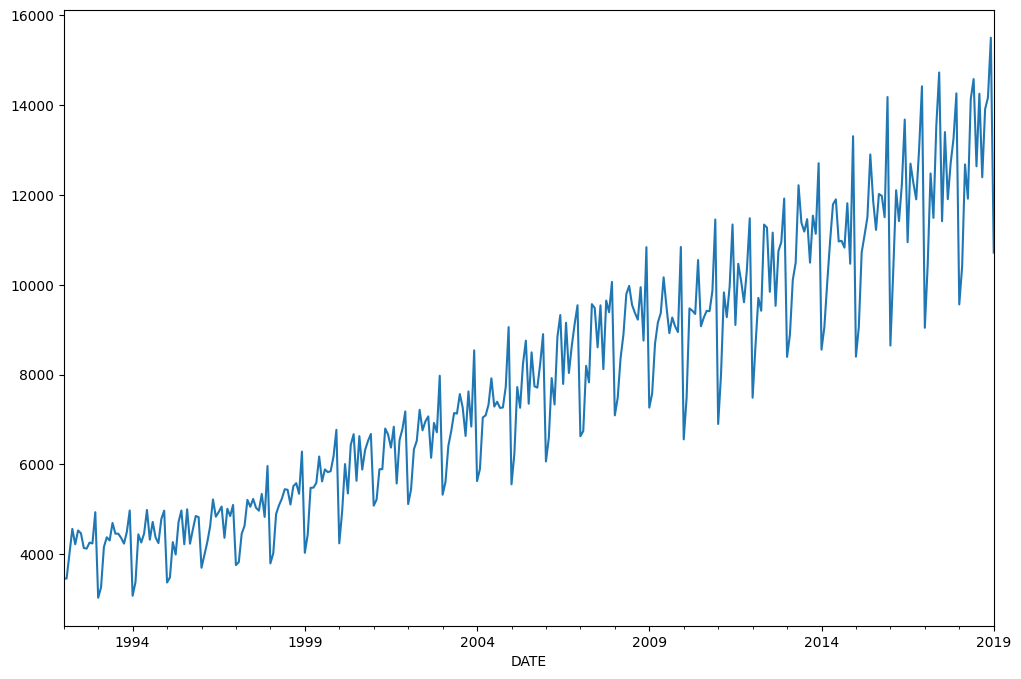

In [6]:
df['Sales'].plot(figsize=(12,8))

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [8]:
results = seasonal_decompose(df['Sales'])

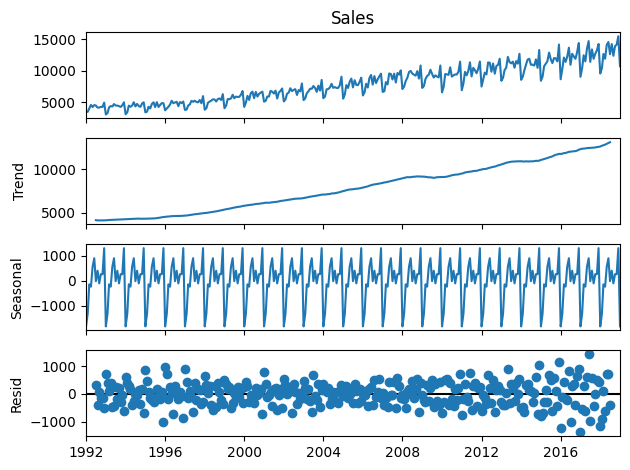

In [10]:
results.plot();

<Axes: xlabel='DATE'>

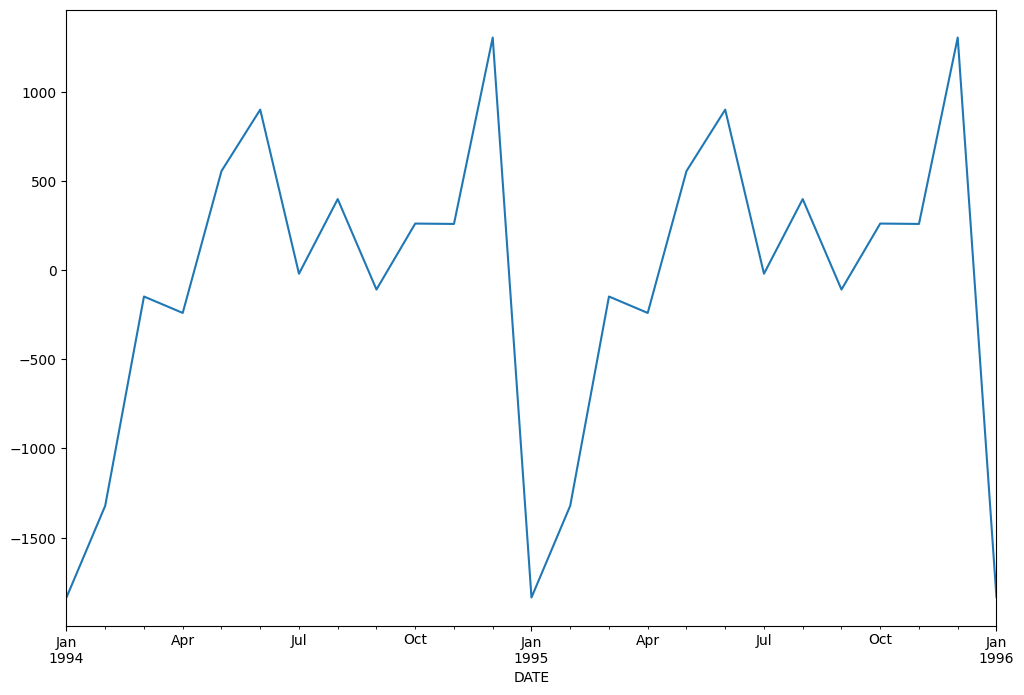

In [13]:
results.seasonal.plot(figsize=(12,8), xlim = ['1994-01-01', '1996-01-01'])

## Train and test split
split 12 month as test

In [14]:
nobs = 12
train = df.iloc[:-nobs]
test = df.iloc[-nobs:]

## Scale data

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
# scale data to 0 - 1 range
scale = MinMaxScaler()

In [17]:
# fit to training data
scale.fit(train)

MinMaxScaler()

In [18]:
scale_train = scale.transform(train)
scale_test = scale.transform(test)

## Time Series generator
This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array containing consecutive data points (timesteps). The data should be at 2D, and axis 0 is expected to be the time dimension.
    targets: Targets corresponding to timesteps in `data`. It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps within sequences. For rate `r`, timesteps `data[i]`, `data[i-r]`, ... `data[i - length]` are used for create a sample sequence.
    stride: Period between successive output sequences. For stride `s`, consecutive output samples would be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used in the output sequences. This is useful to reserve part of the data for test or validation.
    end_index: Data points later than `end_index` will not be used in the output sequences. This is useful to reserve part of the data for test or validation.
    shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be in reverse chronological order.
    batch_size: Number of timeseries samples in each batch (except maybe the last one).

In [19]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [20]:
# define generator
n_input = 2
n_features = 1
generator = TimeseriesGenerator(scale_train, scale_train, length = n_input, batch_size = 1)

In [21]:
print('length of scale_train data is: ', len(scale_train))
print('length of generator train data is: ', len(generator))


length of scale_train data is:  313
length of generator train data is:  311


In [22]:
# What does the first batch look like?
X, y = generator[0]

print(f'Given the array: \n {X.flatten()}')
print(f'Predict this y: \n {y}')

Given the array: 
 [0.03658432 0.03649885]
Predict this y: 
 [[0.08299855]]


In [23]:
# Now let's redefine the get the 12month data and predict the next month out
n_input = 12
generator2 = TimeseriesGenerator(scale_train, scale_train, length = n_input, batch_size = 1)

In [25]:
# What does the first batch look like now?
X, y = generator2[0]

print(f'Given the array: \n {X.flatten()}')
print(f'Predict this y: \n {y}')

Given the array: 
 [0.03658432 0.03649885 0.08299855 0.13103684 0.1017181  0.12804513
 0.12266006 0.09453799 0.09359774 0.10496624 0.10334217 0.16283443]
Predict this y: 
 [[0.]]


## Create the LSTM model

In [35]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras.backend as K

In [58]:
K.clear_session()

In [59]:
# define model
lstm_mdl = Sequential()
lstm_mdl.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
lstm_mdl.add(Dense(1))
lstm_mdl.compile(optimizer='adam', loss='mse')

In [60]:
lstm_mdl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
# fit model
lstm_mdl.fit(generator2, epochs=50)

Epoch 1/50
301/301 [==============================] - 5s 10ms/step - loss: 0.0154
Epoch 2/50
301/301 [==============================] - 4s 12ms/step - loss: 0.0096
Epoch 3/50
301/301 [==============================] - 3s 11ms/step - loss: 0.0078
Epoch 4/50
301/301 [==============================] - 3s 9ms/step - loss: 0.0090
Epoch 5/50
301/301 [==============================] - 3s 11ms/step - loss: 0.0082
Epoch 6/50
301/301 [==============================] - 3s 10ms/step - loss: 0.0063
Epoch 7/50
301/301 [==============================] - 3s 10ms/step - loss: 0.0056
Epoch 8/50
301/301 [==============================] - 4s 14ms/step - loss: 0.0049
Epoch 9/50
301/301 [==============================] - 3s 10ms/step - loss: 0.0035
Epoch 10/50
301/301 [==============================] - 3s 10ms/step - loss: 0.0031
Epoch 11/50
301/301 [==============================] - 3s 11ms/step - loss: 0.0025
Epoch 12/50
301/301 [==============================] - 3s 10ms/step - loss: 0.0024
Epoch 13/50
30

In [62]:
lstm_mdl.history.history.keys()

dict_keys(['loss'])

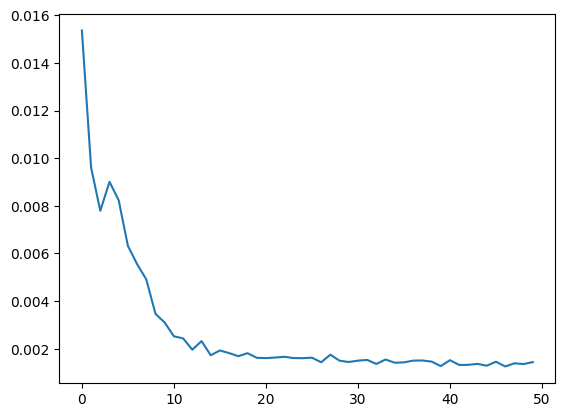

In [63]:
loss_per_epoch = lstm_mdl.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

## Evaluate on Test data

In [64]:
first_eval_batch = scale_train[-12:]

In [65]:
first_eval_batch

array([[0.63432772],
       [0.80776135],
       [0.72313873],
       [0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ]])

In [66]:
n_input = 12
n_features = 1
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [67]:
first_eval_batch.shape

(1, 12, 1)

In [68]:
lstm_mdl.predict(first_eval_batch)

1/1 [==============================] - 0s 193ms/step


array([[0.76058495]], dtype=float32)

In [69]:
print(f'test result: {scale_test[0]}')

test result: [0.63116506]


## Create a loop and predict into all the future in test range

In [71]:
test_predicts = []
first_eval_batch = scale_train[-12:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [72]:
current_batch.shape

(1, 12, 1)

In [74]:
np.append(current_batch[:,1:,:], [[[99]]], axis=1)

array([[[ 0.80776135],
        [ 0.72313873],
        [ 0.89870929],
        [ 1.        ],
        [ 0.71672793],
        [ 0.88648602],
        [ 0.75869732],
        [ 0.82742115],
        [ 0.87443371],
        [ 0.96025301],
        [ 0.5584238 ],
        [99.        ]]])

**NOTE: PAY CLOSE ATTENTION HERE TO WHAT IS BEING OUTPUTED AND IN WHAT DIMENSIONS. ADD YOUR OWN PRINT() STATEMENTS TO SEE WHAT IS TRULY GOING ON!!**

In [80]:
test_predicts = []
first_eval_batch = scale_train[-12:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
for i in range(len(test)):
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
  curr_pred = lstm_mdl.predict(current_batch)[0]

  #store prediction
  test_predicts.append(curr_pred)

  # update current_batch to drop the first value and add the current prediction
  current_batch = np.append(current_batch[:,1:,:], [[curr_pred]], axis=1)


1/1 [==============================] - 0s 70ms/step


In [81]:
test_predicts

[array([0.76058495], dtype=float32),
 array([0.86628276], dtype=float32),
 array([0.83035046], dtype=float32),
 array([0.99152935], dtype=float32),
 array([1.0673684], dtype=float32),
 array([0.8125949], dtype=float32),
 array([0.97762686], dtype=float32),
 array([0.825509], dtype=float32),
 array([0.9193215], dtype=float32),
 array([0.9514203], dtype=float32),
 array([1.0375094], dtype=float32),
 array([0.6674816], dtype=float32)]

## Inverse Transformations and compare

In [82]:
true_predicts = scale.inverse_transform(test_predicts)

In [83]:
true_predicts

array([[11929.08333528],
       [13165.64202207],
       [12745.27001542],
       [14630.90181315],
       [15518.14277327],
       [12537.54762506],
       [14468.2566368 ],
       [12688.62992841],
       [13786.14196426],
       [14161.66617346],
       [15168.82295465],
       [10839.86725289]])

In [84]:
test

,Sales
DATE,
2018-02-01,10415
2018-03-01,12683
2018-04-01,11919
2018-05-01,14138
2018-06-01,14583
2018-07-01,12640
2018-08-01,14257
2018-09-01,12396
2018-10-01,13914


In [85]:
test['Predictions'] = true_predicts

<ipython-input-85-29e3cb02dc25>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predicts


In [86]:
test

,Sales,Predictions
DATE,,
2018-02-01,10415,11929.083335
2018-03-01,12683,13165.642022
2018-04-01,11919,12745.270015
2018-05-01,14138,14630.901813
2018-06-01,14583,15518.142773
2018-07-01,12640,12537.547625
2018-08-01,14257,14468.256637
2018-09-01,12396,12688.629928
2018-10-01,13914,13786.141964


<Axes: xlabel='DATE'>

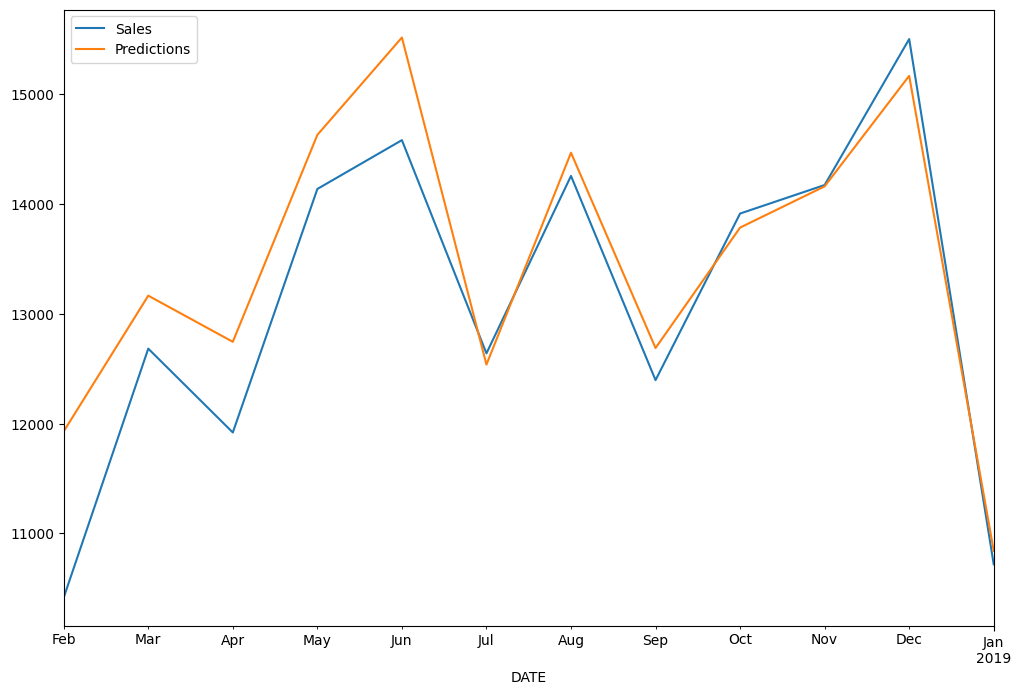

In [87]:
test.plot(figsize=(12,8))

## Saving and Loading models

In [88]:
lstm_mdl.save('rnn_models_sales.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [91]:
pwd

'/content'

## Load a model

In [89]:
from keras.models import load_model

In [90]:
new_mdl = load_model('rnn_models_sales.h5')
new_mdl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
